# Team 6 Final Project
Chaim Gross, Eytan Slotnik, Tomer Fried, Naftali Arnold
## 11/01/2023

After going through the map which presents fires by their causes, and trying to create location-based features, we have gotten to see that:
- The location-based features, which are based on data that latitude and longitude features already produce, do not improve accuracy significantly
- The reason for that might be that latitude and longitude already explain their variance within them

Therefore, we decided to swift our efforts to feature engineering which is based on data, that does not already apparent, but rather missing in the data, such as:
- Social- Economic data, location based
- Density of population, location based

So as a start, we add these, using datasets in kaggle, which occur in the US at similar times:

In [2]:
import folium as folium
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import rtree
import haversine
from sklearn import preprocessing
import geopandas as gpd

In [3]:
def create_date_faetures(df):
    """
    creates data features from YEAR and DOY.
    create a new column of date which is calculated from FIRE_YEAR and DISCOVERY_DOY, and extract from there features
    :param df: data
    :return: a new dataframe containing only the features we added
    """
    from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

    features = pd.DataFrame()
    df["DISCOVERY_DATE"] = pd.to_datetime(df['FIRE_YEAR'] * 1000 + df['DISCOVERY_DOY'], format='%Y%j')
    cal = calendar()

    # is holiday feature
    holidays = cal.holidays(start=df["DISCOVERY_DATE"].min(), end=df["DISCOVERY_DATE"].max())
    features['IS_HOLIDAY'] = df['DISCOVERY_DATE'].isin(holidays).astype(int)

    # is fourth of july feature
    features['IS_4TH_JULY'] = df['DISCOVERY_DATE'].apply(lambda date: 1 if date.strftime("%B %d") == "July 04" else 0)

    # is weekend feature
    features['IS_WEEKEND'] = dayofweek = df["DISCOVERY_DATE"].dt.dayofweek
    features['IS_WEEKEND'][dayofweek >= 5] = 1
    features['IS_WEEKEND'][dayofweek < 5]  = 0

    features["WEST_TO_10W"] = np.where(df['LONGITUDE'] >= -100, 1, 0)

    # month dummies
    month_dummies = pd.get_dummies(df["DISCOVERY_DATE"].dt.month, prefix="MONTH", drop_first=True)
    features = pd.concat([features, month_dummies], axis=1)

    return features



In [28]:
def get_smoking_rate_feature(df):
    smoking_rate_dict = {'AL': 0.209, 'AK': 0.21, 'AZ': 0.156, 'AR': 0.223, 'CA': 0.113, 'CO': 0.146, 'CT': 0.127, 'DE': 0.17, 'DC': 0.143, 'FL': 0.161, 'GA': 0.175, 'HI': 0.128, 'ID': 0.143, 'IL': 0.155, 'IN': 0.218, 'IA': 0.171, 'KS': 0.174, 'KY': 0.246, 'LA': 0.231, 'ME': 0.173, 'MD': 0.138, 'MA': 0.137, 'MI': 0.193, 'MN': 0.145, 'MS': 0.222, 'MO': 0.208, 'MT': 0.172, 'NE': 0.154, 'NV': 0.176, 'NH': 0.157, 'NJ': 0.137, 'NM': 0.175, 'NY': 0.141, 'NC': 0.172, 'ND': 0.183, 'OH': 0.211, 'OK': 0.201, 'OR': 0.161, 'PA': 0.187, 'RI': 0.149, 'SC': 0.188, 'SD': 0.193, 'TN': 0.226, 'TX': 0.157, 'UT': 0.089, 'VT': 0.158, 'VA': 0.164, 'WA': 0.135, 'WV': 0.26, 'WI': 0.16, 'WY': 0.187, 'PR' : 0.096}

    feature = df["STATE"].map(smoking_rate_dict)
    return feature

In [5]:
def add_density_features(df):

    us_state_to_abbrev = {
        "Alabama": "AL",
        "Alaska": "AK",
        "Arizona": "AZ",
        "Arkansas": "AR",
        "California": "CA",
        "Colorado": "CO",
        "Connecticut": "CT",
        "Delaware": "DE",
        "Florida": "FL",
        "Georgia": "GA",
        "Hawaii": "HI",
        "Idaho": "ID",
        "Illinois": "IL",
        "Indiana": "IN",
        "Iowa": "IA",
        "Kansas": "KS",
        "Kentucky": "KY",
        "Louisiana": "LA",
        "Maine": "ME",
        "Maryland": "MD",
        "Massachusetts": "MA",
        "Michigan": "MI",
        "Minnesota": "MN",
        "Mississippi": "MS",
        "Missouri": "MO",
        "Montana": "MT",
        "Nebraska": "NE",
        "Nevada": "NV",
        "New Hampshire": "NH",
        "New Jersey": "NJ",
        "New Mexico": "NM",
        "New York": "NY",
        "North Carolina": "NC",
        "North Dakota": "ND",
        "Ohio": "OH",
        "Oklahoma": "OK",
        "Oregon": "OR",
        "Pennsylvania": "PA",
        "Rhode Island": "RI",
        "South Carolina": "SC",
        "South Dakota": "SD",
        "Tennessee": "TN",
        "Texas": "TX",
        "Utah": "UT",
        "Vermont": "VT",
        "Virginia": "VA",
        "Washington": "WA",
        "West Virginia": "WV",
        "Wisconsin": "WI",
        "Wyoming": "WY",
        "District of Columbia": "DC",
        "American Samoa": "AS",
        "Guam": "GU",
        "Northern Mariana Islands": "MP",
        "Puerto Rico": "PR",
        "United States Minor Outlying Islands": "UM",
        "U.S. Virgin Islands": "VI",
    }
    us_abbrev_to_state = {v: k for k, v in us_state_to_abbrev.items()}

    density_df = pd.read_csv("apportionment.csv")

    df["ROUNDED_YEAR"] = df["FIRE_YEAR"].apply(lambda x: (x//10) * 10)
    df["DENSITY"] = df.apply(
        lambda row: density_df[(density_df["Name"] == us_abbrev_to_state[row["STATE"]]) &
                               (density_df["Year"] == row["ROUNDED_YEAR"])][["Resident Population Density"]].values[0, 0], axis=1).values

    return df

In [6]:
def pre_process_data(data):
    data = add_density_features(data)
    features = create_date_faetures(data)
    data = data.merge(features, left_index=True, right_index=True)
    data["STATE_SMOKING_RATE"] = get_smoking_rate_feature(data)
    # One-Hot Encoding
    for f in ['STATE', 'FIRE_YEAR']: # add months
        data = pd.get_dummies(data,prefix=[f], columns = [f], drop_first=True)

    # Ordinal Encoding
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    le.fit(data['FIRE_SIZE_CLASS'])
    data['FIRE_SIZE_CLASS'] = le.transform(data['FIRE_SIZE_CLASS']) + 1

    def is_south_east_state(df):
        return df["STATE_FL"]+df["STATE_AL"]+df["STATE_GA"]+df["STATE_SC"]+df["STATE_MS"]+df["STATE_TN"]+df["STATE_NC"]

    data["IS_SOUTH_EAST"] = np.where(is_south_east_state(data) == 1, 1, 0)

    columns_to_drop = ['OBJECTID', 'FOD_ID', 'FPA_ID', 'NWCG_REPORTING_UNIT_ID',
               'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
               'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME', 'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME','COMPLEX_NAME', 'OWNER_CODE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME', "Shape", "DISCOVERY_TIME", "CONT_TIME",
               "OWNER_DESCR", "DISCOVERY_DATE", "DISCOVERY_DOY", "CONT_DOY", "CONT_DATE", "FIRE_SIZE",
                "SOURCE_SYSTEM", "SOURCE_SYSTEM_TYPE", "NWCG_REPORTING_AGENCY", "STAT_CAUSE_DESCR"]

    data = data.drop(columns = columns_to_drop)

    return data



In [7]:
conn = sqlite3.connect('FPA_FOD_20170508.sqlite')
raw_df = pd.read_sql_query("SELECT * from Fires", conn)
raw_df["STAT_CAUSE_CODE"] = raw_df["STAT_CAUSE_CODE"].astype(int)
X, y = raw_df.drop(columns = ["STAT_CAUSE_CODE"]), raw_df.filter(items = ["STAT_CAUSE_CODE"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)
df = X_train.merge(y_train, left_index=True, right_index=True)
X_train = pre_process_data(X_train)
X_test = pre_process_data(X_test)

C:\Users\t-tomerfried\AppData\Local\Temp\ipykernel_16660\2807412305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['IS_WEEKEND'][dayofweek >= 5] = 1
C:\Users\t-tomerfried\AppData\Local\Temp\ipykernel_16660\2807412305.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['IS_WEEKEND'][dayofweek < 5]  = 0
C:\Users\t-tomerfried\AppData\Local\Temp\ipykernel_16660\2807412305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

In [8]:
income_df = pd.read_csv("kaggle_income.csv", encoding="latin1").drop_duplicates(subset=['Lat', "Lon"])
income_locations = [(row["Lat"], row["Lon"]) for _, row in income_df.iterrows()]

In [9]:
def create_index(locations):
    index = rtree.index.Index()
    for i, location in enumerate(locations):
        index.insert(i, location)
    return index

index = create_index(income_locations)
def add_income_features(df):

    def find_closest_location(target_row):
        target_location = (target_row["LATITUDE"], target_row["LONGITUDE"])
        closest_location = None
        closest_distance = float("inf")
        for i in index.nearest(target_location, 1):
            location = income_locations[i]
            distance = haversine.haversine(location, target_location)
            if distance < closest_distance:
                closest_location = location
                closest_distance = distance
        return closest_location

    df["closest_location"] = df.apply(find_closest_location, axis=1)

    df[['Lat', 'Lon']] = df["closest_location"].apply(lambda x: pd.Series(x))
    df = pd.merge(df, income_df, on=['Lat', 'Lon'], how="left")
    df = df.drop(columns = ['id', 'State_Code', 'State_Name', 'State_ab', 'Zip_Code', 'Area_Code', 'Lat', "Lon", 'closest_location'])
    return df

In [10]:
X_train = add_income_features(X_train)
X_test = add_income_features(X_test)

In [11]:
def encode_income_columns(data):
    # One-Hot Encoding
    for f in ['Type', 'Primary']:
        data = pd.get_dummies(data,prefix=[f], columns = [f], drop_first=True)

    # Ordinal Encoding
    le = preprocessing.LabelEncoder()
    for c in ['County', 'City', 'Place']:
        le.fit(data[c])
        data[c] = le.transform(data[c]) + 1

    return data

In [12]:
X_train = encode_income_columns(X_train)
X_test = encode_income_columns(X_test)

In [13]:
X_train['DENSITY'] = X_train['DENSITY'].str.replace(',','').astype(float)
X_test['DENSITY'] = X_test['DENSITY'].str.replace(',','').astype(float)

In [14]:
# rf = RandomForestClassifier(random_state=10).fit(X_train, y_train)
# rf_preds = rf.predict(X_test)
# print("Random Forest accuracy score is:")
# print(accuracy_score(y_test,rf_preds))
# print("Random Forest F1 score is:")
# print(classification_report(y_test,rf_preds, zero_division=0))
#
# feature_importances = sorted(list(zip(X_train.columns, rf.feature_importances_)), key=lambda x: -x[1])
# columns = list(list(zip(*feature_importances))[0])
# importances = list(list(zip(*feature_importances))[1])
# sns.barplot(x=columns, y=importances)
# feature_importances

Wow, an improvement of approximately 3 percent in accuracy. All labels' f1 scores where improved.
Looks like we should continue with this idea in mind, let's try to add proximity to railroad and smoking ratio of every state (added above)

In [33]:
from shapely.geometry import Point
from rtree import index

gdf = gpd.read_file(r"C:\Users\t-tomerfried\Desktop\semester e\shifter\APML\North_American_Rail_Network_Lines\North_American_Rail_Network_Lines.shp", crs="EPSG:3857")
gdf = gdf.to_crs("EPSG:4269")

# Create an index of the rail lines
idx = index.Index()
for i, line in gdf.iterrows():
    idx.insert(i, line.geometry.bounds, obj=line)

In [69]:
def find_closest_line(row):
    # Create a shapely Point object for the location
    loc_point = Point(row["LONGITUDE"], row["LATITUDE"])
    # Find the nearest rail line using the index
    nearest_line = gdf.iloc[list(idx.nearest(loc_point.bounds, 1))[0]]
    # Find the distance between the location and the nearest rail line
    distance = loc_point.distance(nearest_line.geometry)
    return distance

In [70]:
X_train["MIN_DIST_TRAIN"] = X_train.apply(find_closest_line, axis=1)
X_test["MIN_DIST_TRAIN"] = X_test.apply(find_closest_line, axis=1)

C:\Users\t-tomerfried\AppData\Local\Temp\ipykernel_16660\1897862076.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(random_state=10).fit(X_train, y_train)


Random Forest accuracy score is:
0.5610442484652789
Random Forest F1 score is:
              precision    recall  f1-score   support

           1       0.70      0.81      0.75     23271
           2       0.39      0.25      0.31     12469
           3       0.22      0.05      0.08      4428
           4       0.46      0.26      0.33      6387
           5       0.51      0.68      0.58     35799
           6       0.51      0.47      0.49      2753
           7       0.55      0.51      0.53     23178
           8       0.33      0.13      0.19      5139
           9       0.49      0.51      0.50     26972
          10       0.55      0.34      0.42       994
          11       0.23      0.05      0.08      1177
          12       0.14      0.03      0.04       310
          13       0.84      0.83      0.84     13829

    accuracy                           0.56    156706
   macro avg       0.46      0.38      0.40    156706
weighted avg       0.54      0.56      0.54    156706



[('LONGITUDE', 0.11216194382855696),
 ('LATITUDE', 0.1011821081999122),
 ('MIN_DIST_TRAIN', 0.09876926189252325),
 ('DENSITY', 0.041341036767105585),
 ('ALand', 0.040301490688625846),
 ('Mean', 0.03490298690137503),
 ('Stdev', 0.03437958174485427),
 ('sum_w', 0.03426080154848757),
 ('Median', 0.033467458106913026),
 ('City', 0.03325664722029519),
 ('AWater', 0.032264206477610434),
 ('FIRE_SIZE_CLASS', 0.02875590765118941),
 ('IS_WEEKEND', 0.020734488081785525),
 ('ROUNDED_YEAR', 0.01909590054701943),
 ('STATE_SMOKING_RATE', 0.01789893742091055),
 ('County', 0.013240258409293978),
 ('Place', 0.01292296764762904),
 ('MONTH_7', 0.011266860966686172),
 ('MONTH_8', 0.010921436072265726),
 ('MONTH_4', 0.010047349848523027),
 ('MONTH_6', 0.009473074052435278),
 ('WEST_TO_10W', 0.009403722711640899),
 ('MONTH_3', 0.009086847743824825),
 ('MONTH_5', 0.008832209263927936),
 ('FIRE_YEAR_2007', 0.008174147771300272),
 ('FIRE_YEAR_2008', 0.007747051198606627),
 ('MONTH_9', 0.007700149742920606),
 (

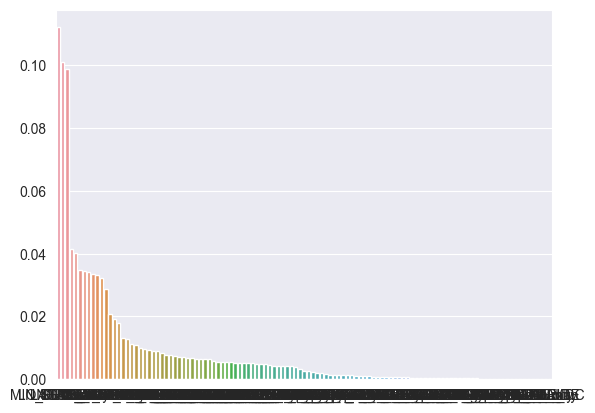

In [75]:
rf = RandomForestClassifier(random_state=10).fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print("Random Forest accuracy score is:")
print(accuracy_score(y_test,rf_preds))
print("Random Forest F1 score is:")
print(classification_report(y_test,rf_preds, zero_division=0))

feature_importances = sorted(list(zip(X_train.columns, rf.feature_importances_)), key=lambda x: -x[1])
columns = list(list(zip(*feature_importances))[0])
importances = list(list(zip(*feature_importances))[1])
sns.barplot(x=columns, y=importances)
feature_importances

from 0.552 to 0.561!! yessss

Let's try to add a feature which indicates whether a storm had occurred at the same time and place of the fire

In [ ]:
year_df_dict = {year: pd.read_csv("StormEvents_details-ftp_v1.0_d"+str(year)+"_c20170717.csv") for year in range(1996, 2015)}

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# Load the fire dataset
fires = pd.read_csv("fires.csv")
# convert the date column to datetime
fires["date"] = pd.to_datetime(fires["date"])

# Convert the fire dataset into a GeoDataFrame
fires_gdf = gpd.GeoDataFrame(fires, geometry=gpd.points_from_xy(fires["longitude"], fires["latitude"]))

# Load the storms dataset
storms = pd.read_csv("storms.csv")
# convert start_date and end_date columns to datetime
storms["start_date"] = pd.to_datetime(storms["start_date"])
storms["end_date"] = pd.to_datetime(storms["end_date"])

# create a new column in the storms dataframe to store the result
storms["storm"] = False

# Convert the storms dataset into a GeoDataFrame
storms_gdf = gpd.GeoDataFrame(storms, geometry=gpd.points_from_xy(storms[["start_longitude","end_longitude"]], storms[["start_latitude","end_latitude"]]))

# Spatial join the two GeoDataFrames
join = gpd.sjoin(fires_gdf, storms_gdf, how="inner", op='intersects')

# group the data by fire and count the number of storms for each fire
fires_with_storms = join.groupby("index_left").size()

# Print the resulting fires dataframe
print(fires_with_storms)


To be continued...

# Next Time
- Lightning data features
- storms data features
- attempt different models and explore predictions